# Cost Surface Generation for Volcano Evacuation

This notebook demonstrates how to create cost surfaces for volcano evacuation modeling. Cost surfaces represent the difficulty of traveling through different terrain and are essential for finding optimal evacuation routes.

## What are Cost Surfaces?

In evacuation modeling, a cost surface represents how difficult or time-consuming it is to traverse each part of the landscape. The cost is influenced by:

1. **Land cover** (forests, grasslands, urban areas, water bodies)
2. **Terrain slope** (uphill, downhill, flat areas)
3. **Infrastructure** (hiking paths, roads)
4. **Natural barriers** (rivers, cliffs)

In this notebook, we'll create comprehensive cost surfaces for two Indonesian volcanoes: Mount Marapi and Mount Awu. These cost surfaces will be used for evacuation path analysis in subsequent notebooks.

## Import Libraries and Custom Modules

First, we need to import the necessary libraries and custom modules:

- **Basic libraries**: numpy, rasterio, geopandas
- **Custom modules**:
  - `data_loading`: Functions for reading raster and vector data
  - `dem_processing`: Functions for slope and walking speed calculations
  - `cost_calculations`: Functions for creating and modifying cost surfaces
  - `plotting_utils`: Functions for visualizing results

In [ ]:
import os
import numpy as np
import rasterio
import geopandas as gpd
from data_loading import read_shapefile, read_raster
from dem_processing import calculate_slope, calculate_walking_speed, normalize_walking_speed
from cost_calculations import (
    map_landcover_to_cost,
    rasterize_layer,
    update_cost_raster,
    adjust_cost_with_walking_speed,
    invert_cost_array,
    invert_walking_speed,
    invert_cost_raster
)
from plotting_utils import (
    plot_continuous_raster_with_points,
    plot_normalized_walking_speed,
    plot_adjusted_cost_raster,
    plot_inverted_cost_raster,
    plot_walking_speed_vs_slope,
    plot_north_east_speed_conservation,
)
from rasterio.plot import plotting_extent

## Define Input Data for Multiple Volcanoes

To make our analysis more robust and comparative, we'll process two different volcanoes:

1. **Mount Marapi** in West Sumatra, Indonesia
2. **Mount Awu** in the Sangihe Islands, Indonesia

For each volcano, we need:
- Digital Elevation Model (DEM)
- Land cover classification raster
- Hiking path vector data
- Stream network vector data
- Summit location vector data

We organize this data in a list of dictionaries for easy iteration.

In [16]:
# Define input data for Marapi and Awu volcanoes
volcanoes = [
    {
        "name": "Marapi",
        "landcover_100m": r"C:\Users\Mojan\Desktop\RA Volcano\Dataset\Marapi_LandCover_2019_100m_Buffer_UTM.tif",
        "DEM_100m": r"C:\Users\Mojan\Desktop\RA Volcano\Dataset\Marapi_DEM_100m_Buffer_UTM.tif",
        "hikingpath_shapefile": r"C:\Users\Mojan\Desktop\RA Volcano\Dataset\Marapi_original_hikinpath_final.gpkg",
        "stream_shapefile": r"C:\Users\Mojan\Desktop\RA Volcano\projection\stream_hydroriver_buffer10m1.gpkg",
        "summit_path": r"C:\Users\Mojan\Desktop\RA Volcano\projection\summit_marapi.gpkg",
    },
    {
        "name": "Awu",
        "landcover_100m": r"C:\Users\Mojan\Desktop\RA Volcano\Dataset\Awu_LandCover_2019_100m_Buffer_UTM.tif",
        "DEM_100m": r"C:\Users\Mojan\Desktop\RA Volcano\Dataset\Awu_DEM_100m_Buffer_UTM.tif",
        "hikingpath_shapefile": r"C:\Users\Mojan\Desktop\RA Volcano\projection\awu_hikingpath_final.shp",
        "stream_shapefile": r"C:\Users\Mojan\Desktop\RA Volcano\projection\stream_awu_final.shp",
        "summit_path": r"C:\Users\Mojan\Desktop\RA Volcano\Dataset\summit_awu_final.gpkg",
    }
]

## Define Cost Mappings for Land Cover

Different land cover types affect travel speed differently. We define "speed conservation values" for each land cover class:

- Values close to 1 represent areas where most of the maximum speed can be maintained
- Values close to 0 represent areas where travel is very slow
- Value of 0 represents impassable areas (like water bodies)
- NaN values represent no data or areas outside our study region

We create two different cost mappings to explore different scenarios:

1. **Original mapping**: Realistic travel speeds based on literature and expert knowledge
2. **Modified mapping**: An extreme scenario where land cover severely restricts movement (useful for sensitivity analysis)

The cost values correspond to the Copernicus Global Land Cover classification system:
- 0: No data
- 30, 40: Grassland and cropland
- 50: Urban/built-up
- 60, 90: Shrubland and herbaceous vegetation
- 112-126: Various forest types
- 80: Water bodies (impassable)

In [18]:
# Define cost mappings
original_cost_mapping = {
    0: np.nan, 30: 0.8333, 40: 0.8333, 50: 0.9091,
    60: 0.5556, 90: 0.5556, 112: 0.8333,
    116: 0.8333, 122: 0.8333, 126: 0.8333, 80: 0
}

modified_cost_mapping = {
    0: np.nan, 30: 0.01, 40: 0.01, 50: 0.01,
    60: 0.01, 90: 0.01, 112: 0.01,
    116: 0.01, 122: 0.01, 126: 0.01, 80: 0
}

cost_mappings = [
    ("original", original_cost_mapping),
    ("modified", modified_cost_mapping)
]

 ##  Create Data Loading Function
 
  we'll create a function that loads all data for a specific volcano. This approach allows each section to stand on its own while maintaining the logic of the original script.

In [19]:
def load_volcano_data(volcano):
    """
    Load all data for a specific volcano.
    
    Args:
        volcano (dict): Dictionary containing file paths for the volcano
        
    Returns:
        dict: Dictionary containing all loaded data and metadata
    """
    volcano_name = volcano["name"]
    print(f"Loading data for {volcano_name}...")
    
    # Load volcano-specific data
    landcover_data, landcover_profile, landcover_transform, landcover_crs, landcover_nodata = read_raster(volcano["landcover_100m"])
    dem_data, dem_profile, dem_transform, dem_crs, dem_nodata = read_raster(volcano["DEM_100m"])
    hiking_path_gdf = read_shapefile(volcano["hikingpath_shapefile"])
    stream_gdf = read_shapefile(volcano["stream_shapefile"])
    summit_gdf = read_shapefile(volcano["summit_path"])

    resolution_x = dem_transform.a
    resolution_y = -dem_transform.e
    extent = plotting_extent(dem_data, dem_transform)
    
    print(f"Successfully loaded data for {volcano_name}")
    
    return {
        "name": volcano_name,
        "landcover_data": landcover_data,
        "landcover_profile": landcover_profile,
        "landcover_transform": landcover_transform,
        "landcover_crs": landcover_crs,
        "landcover_nodata": landcover_nodata,
        "dem_data": dem_data,
        "dem_profile": dem_profile,
        "dem_transform": dem_transform,
        "dem_crs": dem_crs,
        "dem_nodata": dem_nodata,
        "hiking_path_gdf": hiking_path_gdf,
        "stream_gdf": stream_gdf,
        "summit_gdf": summit_gdf,
        "resolution_x": resolution_x,
        "resolution_y": resolution_y,
        "extent": extent
    }

 ##  Load Data for Mount Marapi
 
 Let's load the data for our first volcano, Mount Marapi. This includes:
 
 1. **Land cover raster**: Classification of surface types (forest, grassland, etc.)
 2. **DEM raster**: Digital elevation model providing terrain height
 3. **Hiking paths**: Vector data of existing trails
 4. **Streams**: Vector data of rivers and water courses
 5. **Summit location**: Point data marking the volcano's peak
 
 We also extract important metadata like spatial resolution and extent, which will be used in subsequent calculations.

In [20]:
# Load data for Mount Marapi
marapi_data = load_volcano_data(volcanoes[0])

# Display some basic information
print(f"DEM dimensions: {marapi_data['dem_data'].shape}")
print(f"Land cover dimensions: {marapi_data['landcover_data'].shape}")
print(f"Resolution: {marapi_data['resolution_x']} meters")
print(f"Number of hiking paths: {len(marapi_data['hiking_path_gdf'])}")
print(f"Number of streams: {len(marapi_data['stream_gdf'])}")

Loading data for Marapi...
Successfully loaded data for Marapi
DEM dimensions: (399, 399)
Land cover dimensions: (399, 399)
Resolution: 100.0 meters
Number of hiking paths: 1
Number of streams: 325


 ## 6. Rasterize Vector Data
 
 To incorporate our vector data (hiking paths and streams) into the cost surface calculations, we need to convert them to raster format with the same dimensions as our other rasters.This process is called "rasterization".

 For each vector layer:
 - **Streams**: Assigned a value of 0 (impassable)
 - **Hiking paths**: Assigned a value of 1 (full speed possible)
 
 This allows us to include these features in our cost surface calculations.


In [21]:
def rasterize_vector_data(data):
    """
    Rasterize stream and hiking path vector data to match the land cover raster dimensions.
    
    Args:
        data (dict): Dictionary containing volcano data
        
    Returns:
        tuple: (stream_raster, hiking_path_raster)
    """
    landcover_data = data["landcover_data"]
    landcover_transform = data["landcover_transform"]
    stream_gdf = data["stream_gdf"]
    hiking_path_gdf = data["hiking_path_gdf"]
    
    # Rasterize streams (as barriers - value 0)
    stream_raster = rasterize_layer(
        stream_gdf.geometry, 
        out_shape=landcover_data.shape,
        transform=landcover_transform, 
        burn_value=0
    )
    
    # Rasterize hiking paths (as preferred routes - value 1)
    hiking_path_raster = rasterize_layer(
        hiking_path_gdf.geometry, 
        out_shape=landcover_data.shape,
        transform=landcover_transform, 
        burn_value=1
    )
    
    return stream_raster, hiking_path_raster

# Rasterize vector data for Marapi
marapi_stream_raster, marapi_hiking_path_raster = rasterize_vector_data(marapi_data)

print("Vector data rasterized successfully")
print(f"Stream raster shape: {marapi_stream_raster.shape}")
print(f"Hiking path raster shape: {marapi_hiking_path_raster.shape}")

Vector data rasterized successfully
Stream raster shape: (399, 399)
Hiking path raster shape: (399, 399)


##  Calculate Slopes and Walking Speeds

 Slope is a critical factor affecting travel speed in mountainous terrain.We calculate slopes in 8 directions (N, NE, E, SE, S, SW, W, NW) to account for directional effects. This is important because:
 
 1. Going downhill is generally faster than going uphill
 2. The direction of travel affects the experienced slope
 3. In evacuation scenarios, people may need to travel in different directions

 After calculating slopes, we use Tobler's hiking function to estimate walking speeds:
 
 $W = 6 \times e^{-3.5 \times |S + 0.05|}$
 
 Where:
 - $W$ is the walking speed in km/h
 - $S$ is the slope in rise/run form (not degrees)
 - The function is maximized at a slight downhill slope of -0.05 (approximately -3°)
 
 Finally, we normalize these speeds to get a ratio of actual speed to maximum possible speed.

In [31]:
import rasterio
import numpy as np

def calculate_terrain_effects(data, volcano_name):
    """
    Calculate slopes, walking speeds, and save inverted cost raster for a given volcano.
    
    Args:
        data (dict): Dictionary containing volcano data
        volcano_name (str): Name of the volcano for automatic file naming
    
    Returns:
        tuple: (slope_array, walking_speed_array, normalized_walking_speed_array, inverted_walking_speed_array)
    """
    dem_data = data["dem_data"]
    resolution_x = data["resolution_x"]
    resolution_y = data["resolution_y"]
    dem_nodata = data["dem_nodata"]
    dem_crs = data.get("dem_crs", None)
    dem_transform = data.get("dem_transform", None)
    
    # Calculate slopes in 8 directions
    slope_array = calculate_slope(dem_data, resolution_x, resolution_y, dem_nodata)
    
    # Calculate walking speeds using Tobler's hiking function
    walking_speed_array = calculate_walking_speed(slope_array)
    
    # Normalize walking speeds
    normalized_walking_speed_array = normalize_walking_speed(walking_speed_array)
    
    # Invert walking speeds
    from cost_calculations import invert_walking_speed
    inverted_walking_speed_array = invert_walking_speed(normalized_walking_speed_array)
    
    # Save inverted cost raster
    inverted_cost_raster_path = rf"C:\Users\Mojan\Desktop\RA Volcano\Python Code\contribution rate\inverted_Slopecost_8_directions_{volcano_name}_OriginalLandcover.tif"
    
    # Ensure the array has the correct dimensions
    if len(inverted_walking_speed_array.shape) == 2:
        inverted_walking_speed_array = np.expand_dims(inverted_walking_speed_array, axis=0)
    
    with rasterio.open(
        inverted_cost_raster_path,
        'w',
        driver='GTiff',
        height=inverted_walking_speed_array.shape[1],
        width=inverted_walking_speed_array.shape[2],
        count=8,
        dtype=np.float32,
        crs=dem_crs,
        transform=dem_transform,
        nodata=np.nan
    ) as dst:
        for band in range(8):
            dst.write(inverted_walking_speed_array[band], band + 1)
    
    return slope_array, walking_speed_array, normalized_walking_speed_array, inverted_walking_speed_array

# Calculate terrain effects for Marapi
marapi_slope_array, marapi_walking_speed_array, marapi_normalized_walking_speed_array, marapi_inverted_walking_speed_array = calculate_terrain_effects(marapi_data, "Marapi")

print("Terrain effects calculated successfully")
print(f"Slope array shape: {marapi_slope_array.shape}")
print(f"Walking speed array shape: {marapi_walking_speed_array.shape}")
print(f"Normalized walking speed array shape: {marapi_normalized_walking_speed_array.shape}")

Terrain effects calculated successfully
Slope array shape: (8, 399, 399)
Walking speed array shape: (8, 399, 399)
Normalized walking speed array shape: (8, 399, 399)


 ##  Visualize Slope and Walking Speed
 
 To better understand the terrain effects on travel, we'll create several visualizations:
 
 1. **Slopes in 8 Directions**: Shows how slope varies in different directions around the volcano
 2. **Walking Speed in 8 Directions**: Shows how Tobler's hiking function predicts walking speed in each direction
 3. **Walking Speed vs. Slope**: Shows the relationship between slope angle and walking speed
 4. **Normalized Walking Speed**: Shows the speed conservation values based on slope
 
 These visualizations help us understand:
 - How terrain affects evacuation speed
 - Which areas might be challenging to traverse
 - The directional dependencies of evacuation speed

C:\Users\Mojan\Desktop\RA Volcano\Python Code\contribution rate\plotting_utils.py:344: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 0.95])  # Adjust layout to give space for colorbar


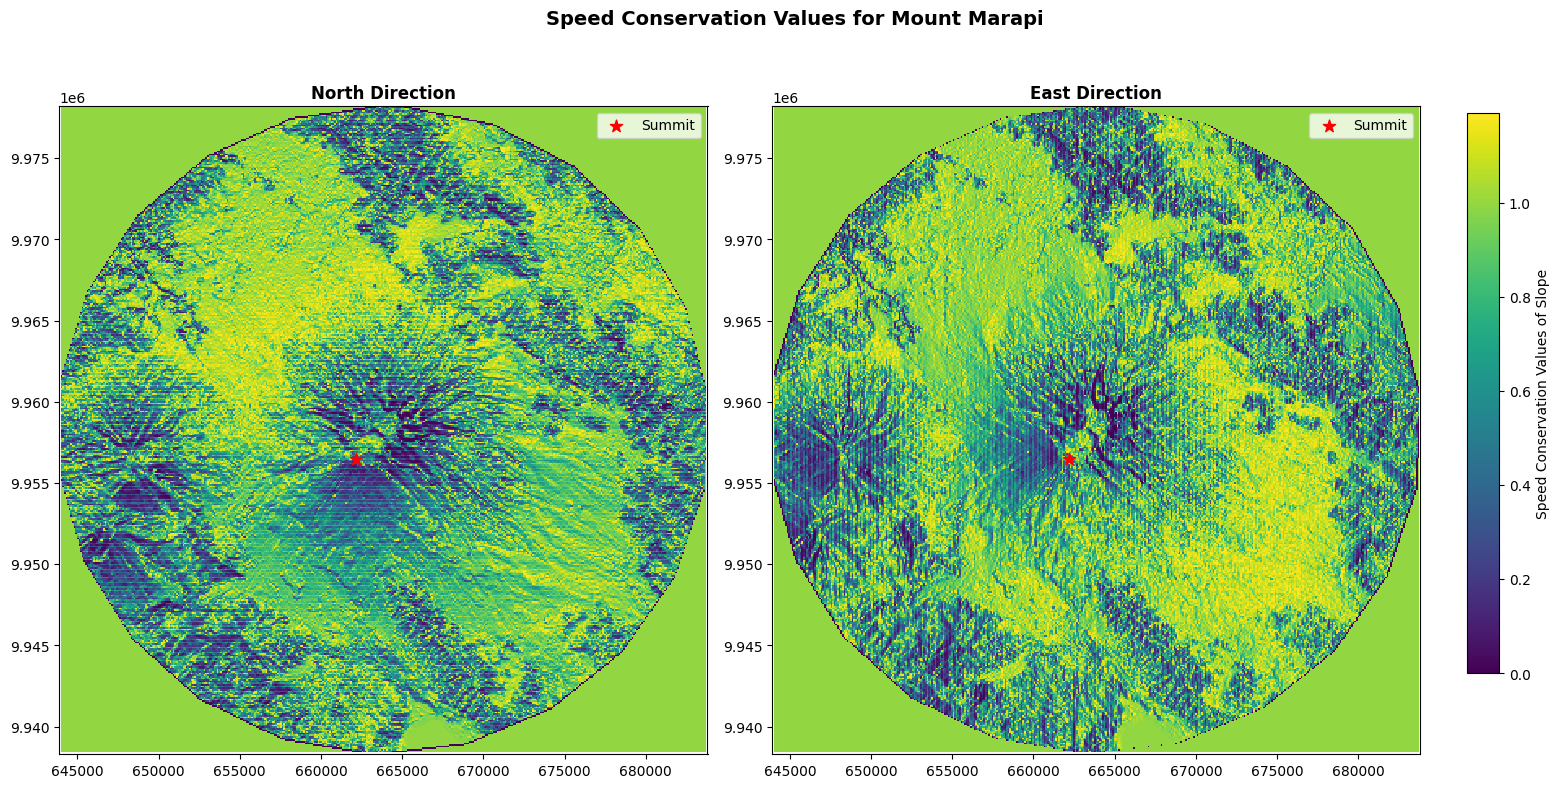

Created terrain effect visualizations for Marapi


In [9]:
def visualize_terrain_effects(data, normalized_walking_speed_array):
    """
    Create visualizations of slope and walking speed effects.
    
    Args:
        data (dict): Dictionary containing volcano data
        slope_array (ndarray): Array of slopes in 8 directions
        walking_speed_array (ndarray): Array of walking speeds in 8 directions
        normalized_walking_speed_array (ndarray): Array of normalized walking speeds
    """
    volcano_name = data["name"]
    extent = data["extent"]
    summit_gdf = data["summit_gdf"]
    
    # Plot North-East speed conservation comparison
    plot_north_east_speed_conservation(
        normalized_walking_speed_array=normalized_walking_speed_array, 
        extent=extent, 
        points_gdf=summit_gdf,
        title=f"Speed Conservation Values for Mount {volcano_name}",
        output_file_path=f"{volcano_name}_north_east_speed_conservation.jpg"
    )
    
    print(f"Created terrain effect visualizations for {volcano_name}")

# Visualize terrain effects for Marapi
visualize_terrain_effects(
    marapi_data, 
    marapi_normalized_walking_speed_array
)

 ## Create Land Cover Cost Raster
 
 Now, we'll create a cost raster based on land cover types. We'll do this for both the original and modified cost mappings to explore different scenarios.

 For each cost mapping scenario:
 
 1. We apply our cost mapping to the land cover data, translating land cover classes into speed conservation values
 2. We update this raster by incorporating streams (as barriers) and hiking paths (as preferred routes)
 3. We save the updated cost raster for documentation and potential reuse
 4. We create a visualization showing the speed conservation values across the study area
 
 This step focuses on the effects of surface features (land cover, streams, paths) on travel speed, before considering terrain slope.

Created and saved land cover cost raster for Marapi with original mapping
Created and saved land cover cost raster for Marapi with modified mapping


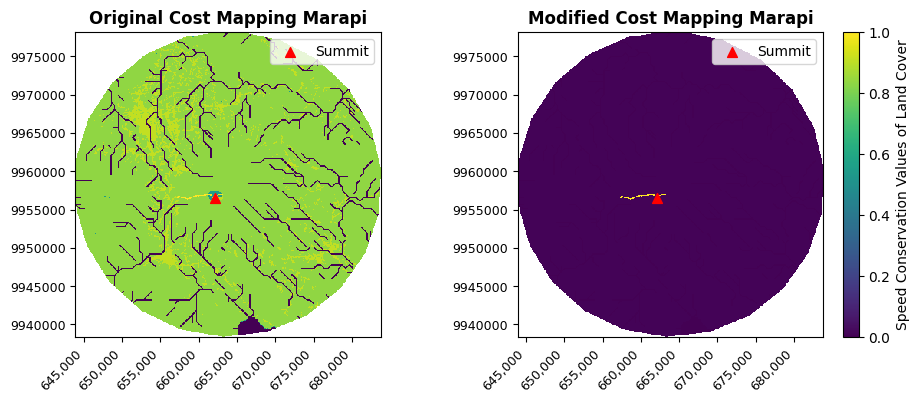

Created comparison plot for Marapi


In [10]:
# Create land cover cost rasters for Marapi with different cost mappings
def create_land_cover_cost_raster(data, stream_raster, hiking_path_raster, cost_mapping, name):
    """
    Create a cost raster based on land cover, streams, and hiking paths.
    
    Args:
        data (dict): Dictionary containing volcano data
        stream_raster (ndarray): Rasterized stream data
        hiking_path_raster (ndarray): Rasterized hiking path data
        cost_mapping (dict): Dictionary mapping land cover classes to costs
        name (str): Name of the cost mapping (e.g., "original", "modified")
        
    Returns:
        ndarray: Updated cost raster
    """
    volcano_name = data["name"]
    landcover_data = data["landcover_data"]
    landcover_transform = data["landcover_transform"]
    landcover_crs = data["landcover_crs"]
    
    # Map land cover to cost
    cost_raster = map_landcover_to_cost(landcover_data, cost_mapping)
    
    # Update cost raster with streams and hiking paths
    updated_cost_raster = update_cost_raster(cost_raster, stream_raster, hiking_path_raster)
    
    # Save updated cost raster
    with rasterio.open(
        f"{volcano_name}_LandCover_Cost_Stream_HikingPath_100m_{name}.tif", 'w', driver='GTiff',
        height=updated_cost_raster.shape[0], width=updated_cost_raster.shape[1],
        count=1, dtype=updated_cost_raster.dtype, crs=landcover_crs, transform=landcover_transform
    ) as dst:
        dst.write(updated_cost_raster, 1)
    
    print(f"Created and saved land cover cost raster for {volcano_name} with {name} mapping")
    
    return updated_cost_raster

# First, create all cost rasters and store them
marapi_cost_rasters = {}
for name, cost_mapping in cost_mappings:
    marapi_cost_rasters[name] = create_land_cover_cost_raster(
        marapi_data, 
        marapi_stream_raster, 
        marapi_hiking_path_raster, 
        cost_mapping, 
        name
    )

# Then, plot the comparison after all rasters have been created
if "original" in marapi_cost_rasters and "modified" in marapi_cost_rasters:
    plot_continuous_raster_with_points(
        raster_data=[marapi_cost_rasters["original"], marapi_cost_rasters["modified"]], 
        extent=marapi_data["extent"],
        points_gdf=marapi_data["summit_gdf"],
        title=["Original Cost Mapping Marapi", "Modified Cost Mapping Marapi"],
        colorbar_label="Speed Conservation Values of Land Cover",
        output_file_path=f"{marapi_data['name']}_cost_mapping_comparison.jpg"
    )
    print(f"Created comparison plot for {marapi_data['name']}")

Created and saved land cover cost raster: Marapi_LandCover_Cost_Stream_HikingPath_100m_original.tif
Created and saved inverted land cover cost raster: invert_landcovercost_original_Marapi.tif
Created and saved land cover cost raster: Marapi_LandCover_Cost_Stream_HikingPath_100m_modified.tif
Created and saved inverted land cover cost raster: invert_landcovercost_modified_Marapi.tif


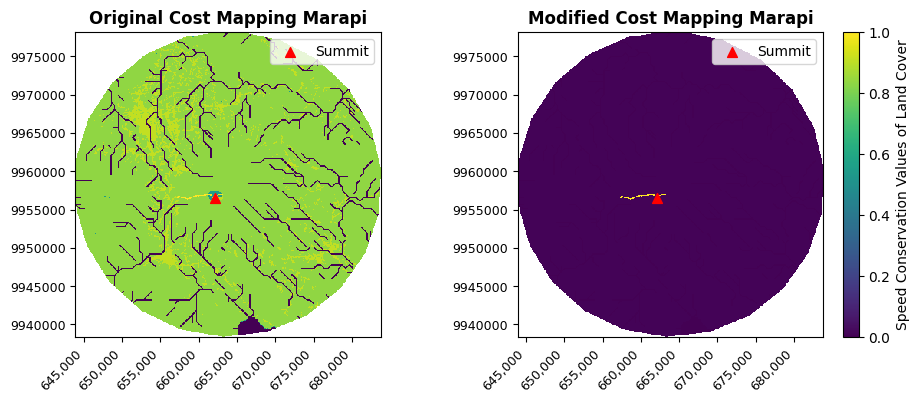

Created comparison plot for Marapi


In [33]:
import rasterio
import numpy as np

# Create land cover cost rasters for a given volcano with different cost mappings (without plotting)
def create_land_cover_cost_raster(data, stream_raster, hiking_path_raster, cost_mapping, name):
    """
    Create a cost raster based on land cover, streams, and hiking paths, and also save the inverted version.

    Args:
        data (dict): Dictionary containing volcano data
        stream_raster (ndarray): Rasterized stream data
        hiking_path_raster (ndarray): Rasterized hiking path data
        cost_mapping (dict): Dictionary mapping land cover classes to costs
        name (str): Name of the cost mapping ("original" or "modified")
        
    Returns:
        tuple: (Updated cost raster, Inverted cost raster)
    """
    volcano_name = data["name"]
    landcover_data = data["landcover_data"]
    landcover_transform = data["landcover_transform"]
    landcover_crs = data["landcover_crs"]
    
    # Map land cover to cost
    cost_raster = map_landcover_to_cost(landcover_data, cost_mapping)
    
    # Update cost raster with streams and hiking paths
    updated_cost_raster = update_cost_raster(cost_raster, stream_raster, hiking_path_raster)
    
    # Save updated cost raster
    cost_raster_filename = f"{volcano_name}_LandCover_Cost_Stream_HikingPath_100m_{name}.tif"
    with rasterio.open(
        cost_raster_filename, 'w', driver='GTiff',
        height=updated_cost_raster.shape[0], width=updated_cost_raster.shape[1],
        count=1, dtype=updated_cost_raster.dtype, crs=landcover_crs, transform=landcover_transform
    ) as dst:
        dst.write(updated_cost_raster, 1)
    
    print(f"Created and saved land cover cost raster: {cost_raster_filename}")

    # Generate and save the inverted cost raster
    inverted_cost_raster = invert_cost_raster(updated_cost_raster)
    
    # Define unique names for the inverted raster
    inverted_raster_filename = f"invert_landcovercost_{name}_{volcano_name}.tif"
    
    with rasterio.open(
        inverted_raster_filename, 'w', driver='GTiff',
        height=inverted_cost_raster.shape[0], width=inverted_cost_raster.shape[1],
        count=1, dtype=inverted_cost_raster.dtype, crs=landcover_crs, transform=landcover_transform
    ) as dst:
        dst.write(inverted_cost_raster, 1)

    print(f"Created and saved inverted land cover cost raster: {inverted_raster_filename}")
    
    return updated_cost_raster, inverted_cost_raster


# Process and save cost rasters for Marapi
marapi_cost_rasters = {}
marapi_inverted_cost_rasters = {}

for name, cost_mapping in cost_mappings:
    updated_raster, inverted_raster = create_land_cover_cost_raster(
        marapi_data, 
        marapi_stream_raster, 
        marapi_hiking_path_raster, 
        cost_mapping, 
        name
    )
    marapi_cost_rasters[name] = updated_raster
    marapi_inverted_cost_rasters[name] = inverted_raster




# Then, plot the comparison after all rasters have been created
if "original" in marapi_cost_rasters and "modified" in marapi_cost_rasters:
    plot_continuous_raster_with_points(
        raster_data=[marapi_cost_rasters["original"], marapi_cost_rasters["modified"]], 
        extent=marapi_data["extent"],
        points_gdf=marapi_data["summit_gdf"],
        title=["Original Cost Mapping Marapi", "Modified Cost Mapping Marapi"],
        colorbar_label="Speed Conservation Values of Land Cover",
        output_file_path=f"{marapi_data['name']}_cost_mapping_comparison.jpg"
    )
    print(f"Created comparison plot for {marapi_data['name']}")


 ##  Combine Land Cover and Slope Effects
 
 Next, we combine the effects of land cover and slope on walking speed:
 
 1. For each of the 8 directions, we multiply:
    - The normalized walking speed due to slope
    - The speed conservation value due to land cover
 
 2. This gives us a comprehensive cost surface that accounts for both factors
 
 3. We also create a scaled version (multiplied by 1.22 m/s) for visualization purposes, which represents actual walking speeds rather than just conservation values

 4. We save both versions as multi-band GeoTIFF files, where each band represents a direction
 
 This combined cost surface provides a more realistic model of evacuation speed across the landscape, accounting for both terrain and surface features.


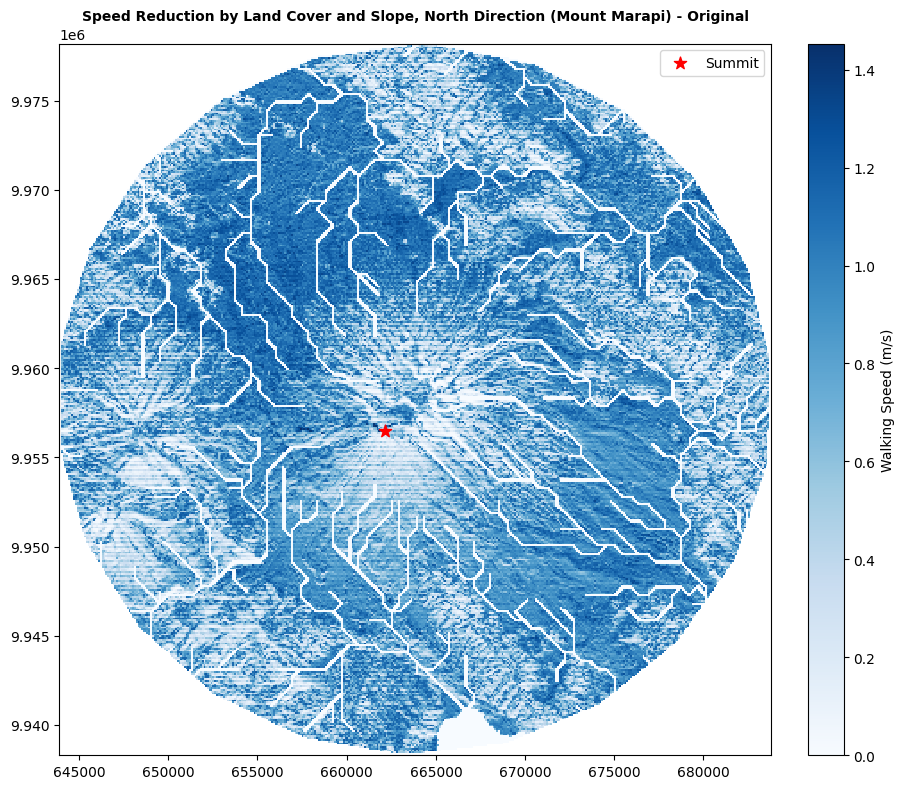

C:\Users\Mojan\miniconda3\envs\py38\lib\site-packages\numpy\lib\function_base.py:4737: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(


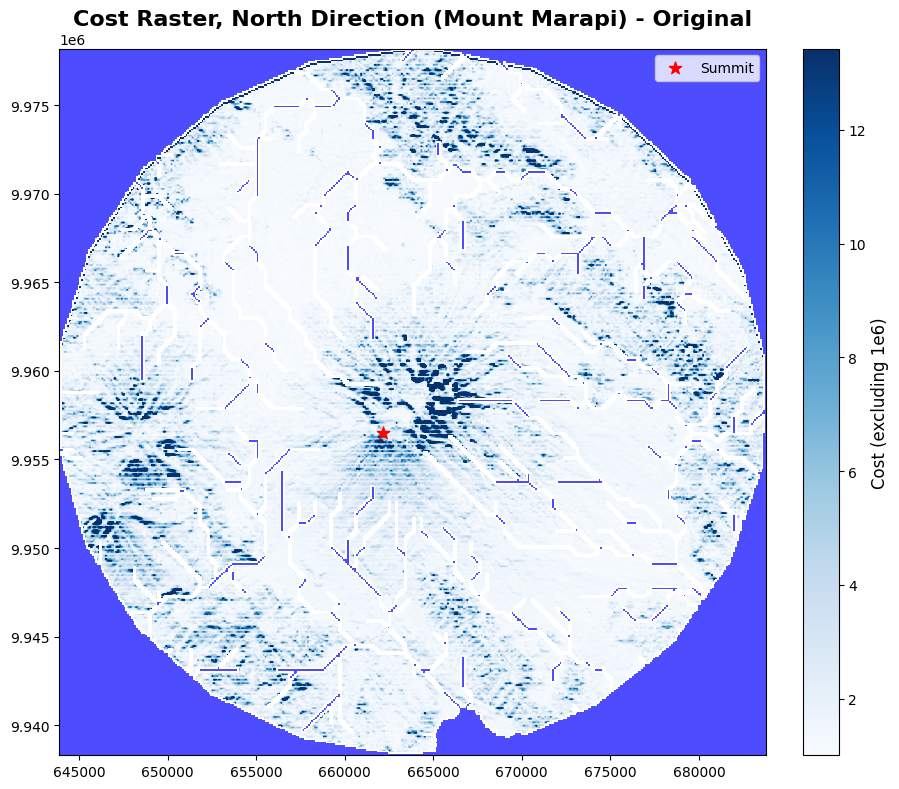

Combined costs for Marapi with original mapping


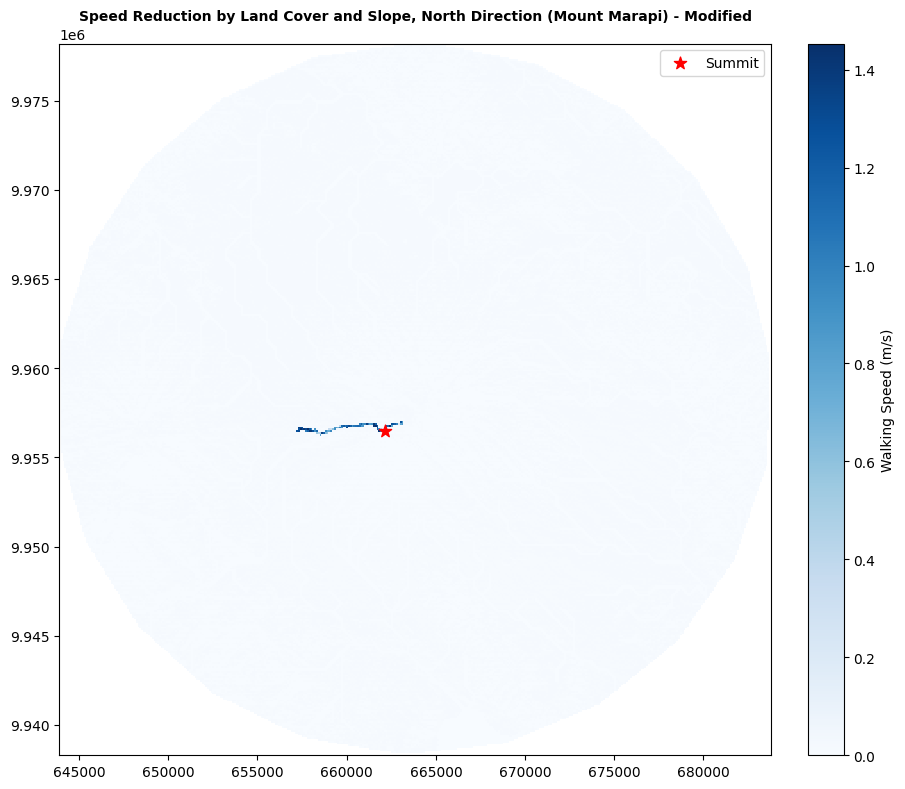

C:\Users\Mojan\miniconda3\envs\py38\lib\site-packages\numpy\lib\function_base.py:4737: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(


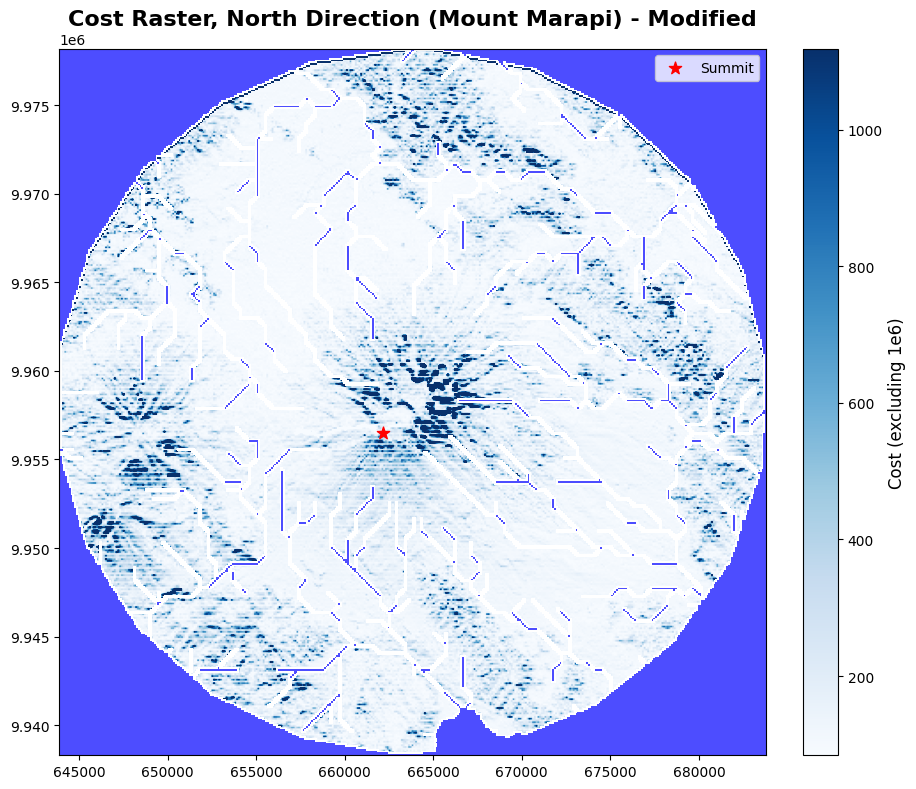

Combined costs for Marapi with modified mapping


In [34]:
def combine_costs(data, normalized_walking_speed_array, updated_cost_raster, name):
    """
    Combine land cover and slope effects on walking speed.
    
    Args:
        data (dict): Dictionary containing volcano data
        normalized_walking_speed_array (ndarray): Array of normalized walking speeds
        updated_cost_raster (ndarray): Updated cost raster based on land cover
        name (str): Name of the cost mapping (e.g., "original", "modified")
        
    Returns:
        tuple: (adjusted_cost_array, scaled_adjusted_cost_array, inverted_cost_array)
    """
    volcano_name = data["name"]
    landcover_transform = data["landcover_transform"]
    landcover_crs = data["landcover_crs"]
    extent = data["extent"]
    summit_gdf = data["summit_gdf"]
    
    # Adjust cost with walking speed
    adjusted_cost_array = adjust_cost_with_walking_speed(normalized_walking_speed_array, updated_cost_raster)
    
    # Scale adjusted cost array for visualization (1.22 m/s is a reference walking speed)
    scaled_adjusted_cost_array = adjusted_cost_array * 1.22
    
    # Save adjusted cost array
    with rasterio.open(
        f"{volcano_name}_adjusted_cost_8_directions_{name}.tif", 'w', driver='GTiff',
        height=adjusted_cost_array.shape[1], width=adjusted_cost_array.shape[2],
        count=8, dtype=np.float32, crs=landcover_crs, transform=landcover_transform,
        nodata=np.nan
    ) as dst:
        for band in range(8):
            dst.write(adjusted_cost_array[band], band + 1)
    
    # Save scaled adjusted cost array
    with rasterio.open(
        f"{volcano_name}_adjusted_cost_8_directions_scaled_{name}.tif", 'w', driver='GTiff',
        height=scaled_adjusted_cost_array.shape[1], width=scaled_adjusted_cost_array.shape[2],
        count=8, dtype=np.float32, crs=landcover_crs, transform=landcover_transform,
        nodata=np.nan
    ) as dst:
        for band in range(8):
            dst.write(scaled_adjusted_cost_array[band], band + 1)
    
    # Visualize adjusted cost (north direction)
    plot_adjusted_cost_raster(
        adjusted_cost_raster=scaled_adjusted_cost_array[0], 
        extent=extent, 
        points_gdf=summit_gdf,
        title=f"Speed Reduction by Land Cover and Slope, North Direction (Mount {volcano_name}) - {name.capitalize()}",
        output_file_path=f"{volcano_name}_Speed_reduction_land_cover_slope_{name}.jpg"
    )
    
    # Invert cost array for path finding
    inverted_cost_array = invert_cost_array(adjusted_cost_array)
    
    # Save inverted cost array
    with rasterio.open(
        f"{volcano_name}_inverted_cost_8_directions_{name}.tif", 'w', driver='GTiff',
        height=inverted_cost_array.shape[1], width=inverted_cost_array.shape[2],
        count=8, dtype=np.float32, crs=landcover_crs, transform=landcover_transform,
        nodata=np.nan
    ) as dst:
        for band in range(8):
            dst.write(inverted_cost_array[band], band + 1)
    
    # Visualize inverted cost (north direction)
    plot_inverted_cost_raster(
        inverted_cost_raster=inverted_cost_array[0], 
        extent=extent, 
        points_gdf=summit_gdf,
        title=f"Cost Raster, North Direction (Mount {volcano_name}) - {name.capitalize()}",
        output_file_path=f"{volcano_name}_InvertedCost_{name}.jpg"
    )
    
    print(f"Combined costs for {volcano_name} with {name} mapping")
    
    return adjusted_cost_array, scaled_adjusted_cost_array, inverted_cost_array

# Combine costs for Marapi with different cost mappings
marapi_combined_costs = {}
for name, cost_mapping in cost_mappings:
    marapi_combined_costs[name] = combine_costs(
        marapi_data, 
        marapi_normalized_walking_speed_array, 
        marapi_cost_rasters[name], 
        name
    )



 ## 11. Repeat for Mount Awu
 
 Now we'll repeat the same process for Mount Awu. This allows us to compare results between different volcanoes and identify common patterns or site-specific challenges.
 
 First, we'll load the data for Mount Awu:

In [35]:
# Load data for Mount Awu
awu_data = load_volcano_data(volcanoes[1])

# Display some basic information
print(f"DEM dimensions: {awu_data['dem_data'].shape}")
print(f"Land cover dimensions: {awu_data['landcover_data'].shape}")
print(f"Resolution: {awu_data['resolution_x']} meters")
print(f"Number of hiking paths: {len(awu_data['hiking_path_gdf'])}")
print(f"Number of streams: {len(awu_data['stream_gdf'])}")

Loading data for Awu...
Successfully loaded data for Awu
DEM dimensions: (400, 401)
Land cover dimensions: (400, 401)
Resolution: 100.0 meters
Number of hiking paths: 1
Number of streams: 16


# Now we'll process Mount Awu through all the same steps:

 1. Rasterize vector data
 2. Calculate terrain effects
 3. Visualize terrain effects
 4. Create land cover cost rasters
 5. Combine costs

C:\Users\Mojan\Desktop\RA Volcano\Python Code\contribution rate\plotting_utils.py:344: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 0.95])  # Adjust layout to give space for colorbar


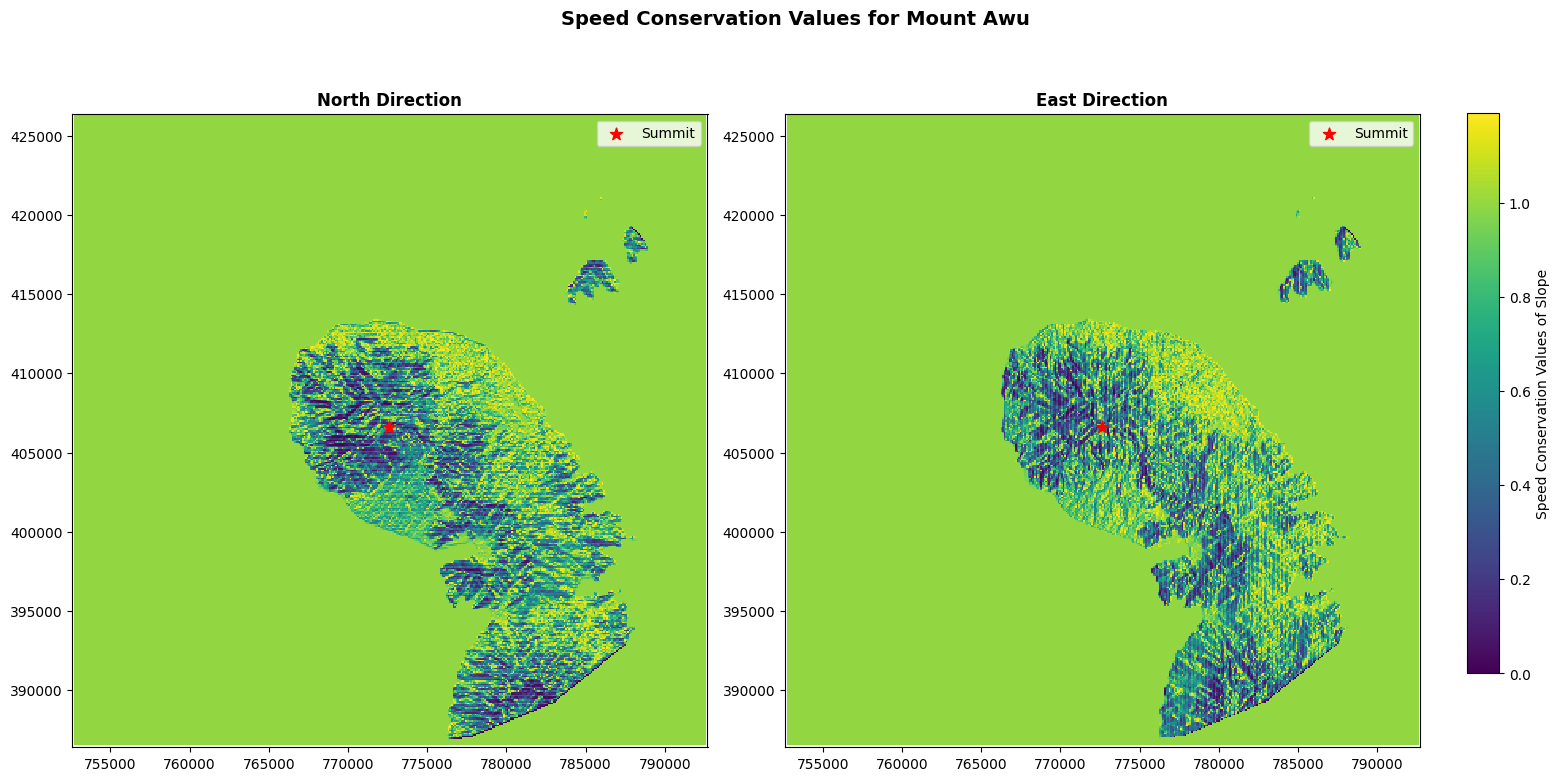

Created terrain effect visualizations for Awu
Created and saved land cover cost raster: Awu_LandCover_Cost_Stream_HikingPath_100m_original.tif
Created and saved inverted land cover cost raster: invert_landcovercost_original_Awu.tif
Created and saved land cover cost raster: Awu_LandCover_Cost_Stream_HikingPath_100m_modified.tif
Created and saved inverted land cover cost raster: invert_landcovercost_modified_Awu.tif
Created and saved land cover cost raster: Awu_LandCover_Cost_Stream_HikingPath_100m_original.tif
Created and saved inverted land cover cost raster: invert_landcovercost_original_Awu.tif
Created and saved land cover cost raster: Awu_LandCover_Cost_Stream_HikingPath_100m_modified.tif
Created and saved inverted land cover cost raster: invert_landcovercost_modified_Awu.tif


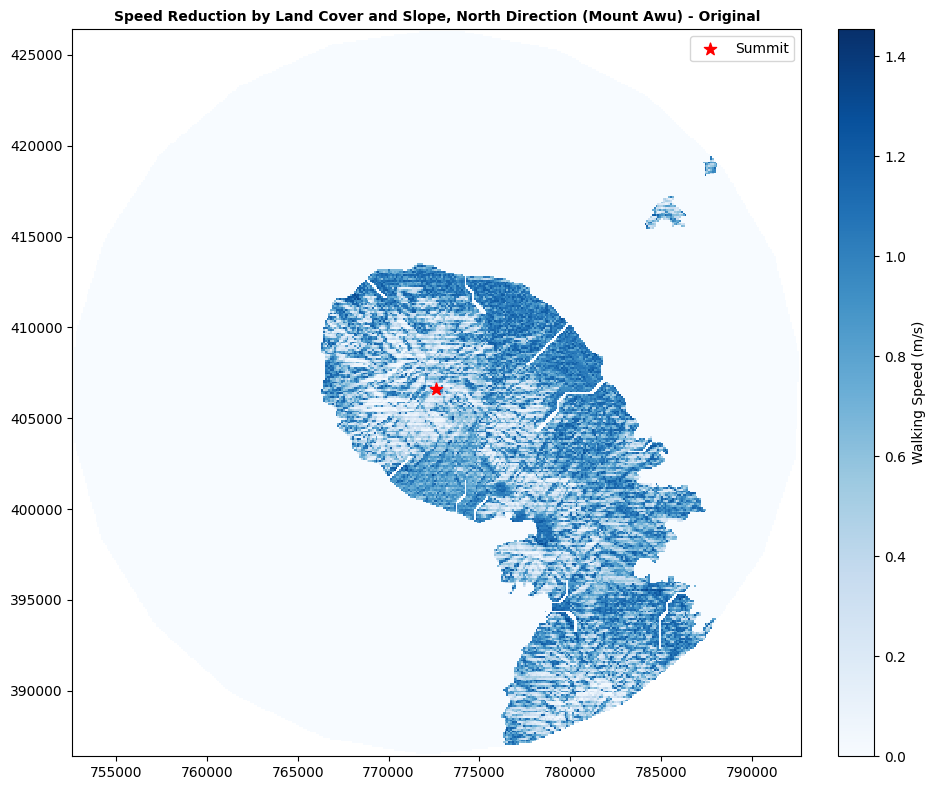

C:\Users\Mojan\miniconda3\envs\py38\lib\site-packages\numpy\lib\function_base.py:4737: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(


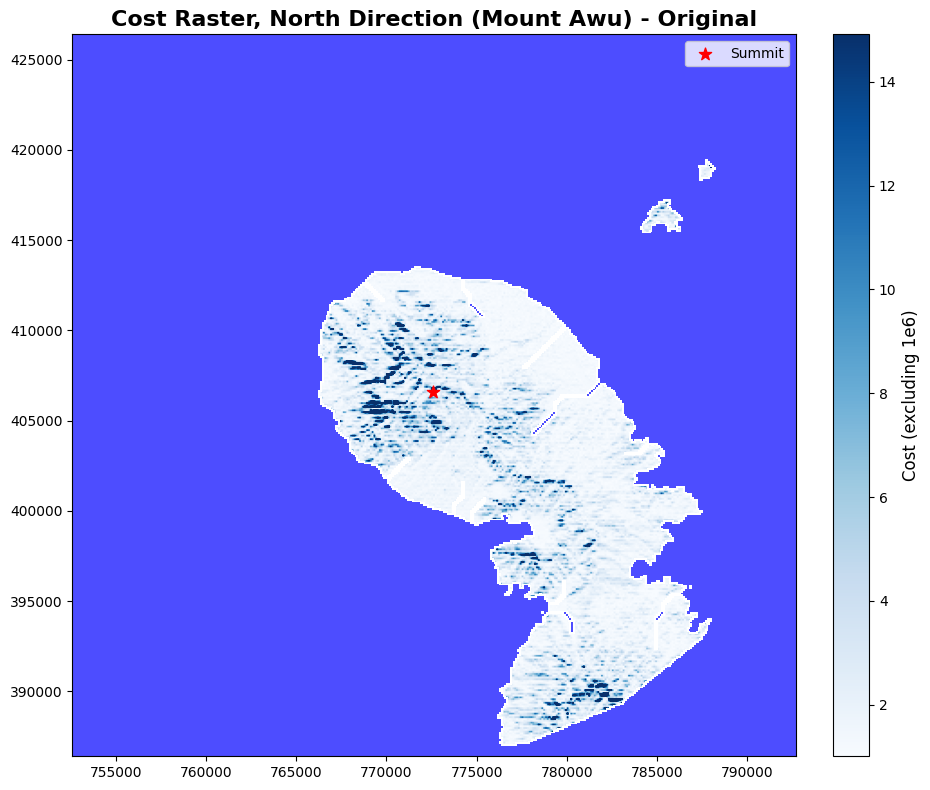

Combined costs for Awu with original mapping


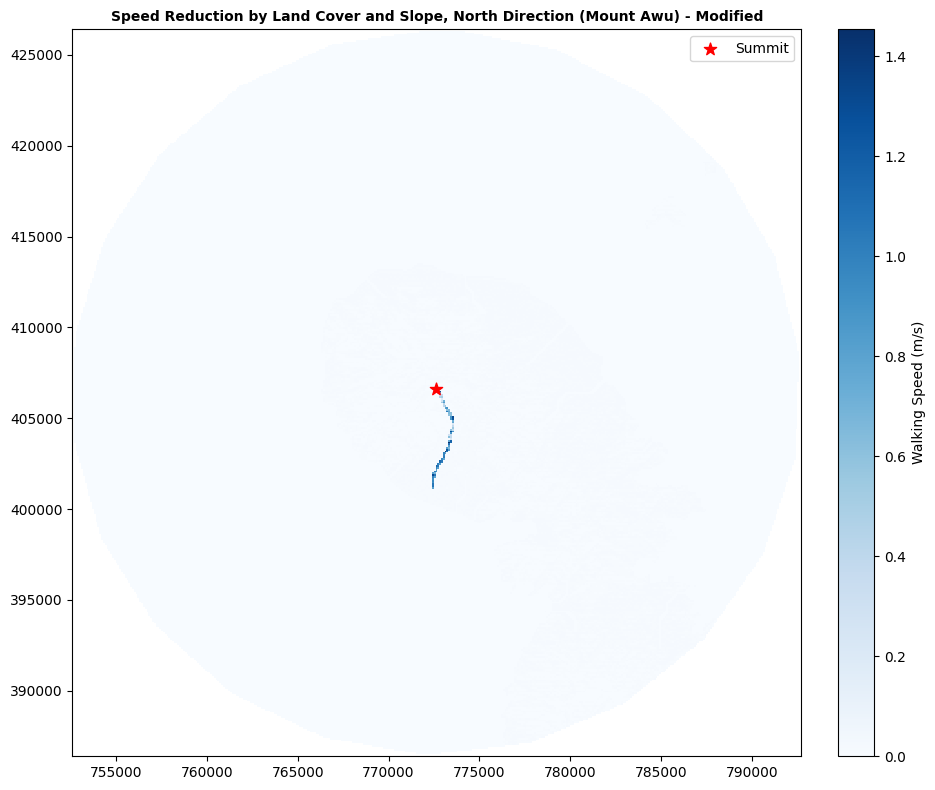

C:\Users\Mojan\miniconda3\envs\py38\lib\site-packages\numpy\lib\function_base.py:4737: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(


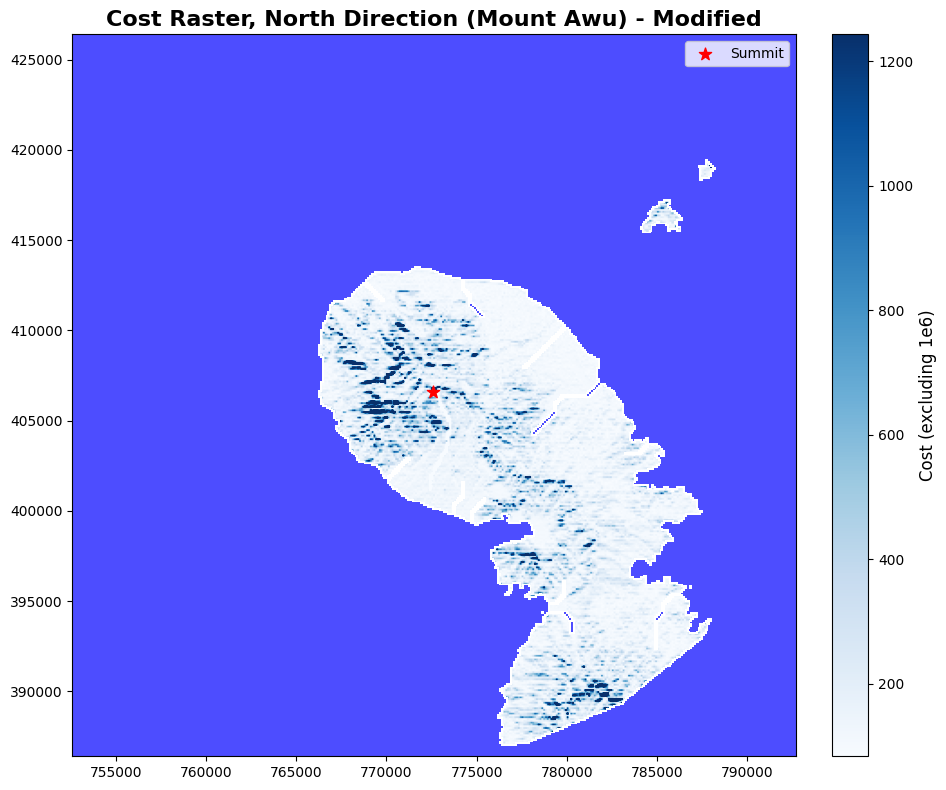

Combined costs for Awu with modified mapping
Completed processing for Mount Awu


In [37]:
# Rasterize vector data for Awu
awu_stream_raster, awu_hiking_path_raster = rasterize_vector_data(awu_data)

# Calculate terrain effects for Awu
awu_slope_array, awu_walking_speed_array, awu_normalized_walking_speed_array, awu_inverted_walking_speed_array = calculate_terrain_effects(awu_data, "Awu")

# Visualize terrain effects for Awu
# Visualize terrain effects for Awu
visualize_terrain_effects(
    awu_data, 
    awu_normalized_walking_speed_array
)

# Create land cover cost rasters for Awu
awu_cost_rasters = {}
for name, cost_mapping in cost_mappings:
    awu_cost_rasters[name] = create_land_cover_cost_raster(
        awu_data, 
        awu_stream_raster, 
        awu_hiking_path_raster, 
        cost_mapping, 
        name
    )
# Process and save cost rasters for Awu
awu_cost_rasters = {}
awu_inverted_cost_rasters = {}

for name, cost_mapping in cost_mappings:
    updated_raster, inverted_raster = create_land_cover_cost_raster(
        awu_data, 
        awu_stream_raster, 
        awu_hiking_path_raster, 
        cost_mapping, 
        name
    )
    awu_cost_rasters[name] = updated_raster
    awu_inverted_cost_rasters[name] = inverted_raster


# Combine costs for Awu
awu_combined_costs = {}
for name, cost_mapping in cost_mappings:
    awu_combined_costs[name] = combine_costs(
        awu_data, 
        awu_normalized_walking_speed_array, 
        awu_cost_rasters[name], 
        name
    )

print("Completed processing for Mount Awu")


 ## 12. Conclusion: Understanding Cost Surfaces for Evacuation
 
 This notebook has demonstrated how to create comprehensive cost surfaces for volcano evacuation analysis. The key insights from this process are:
 
 1. **Multiple Factors Affect Travel Speed**:
    - Land cover types have varying effects on travel speed
    - Terrain slope significantly impacts walking speed, with different effects uphill vs. downhill
    - Infrastructure like hiking paths can greatly improve evacuation speed
    - Natural barriers like streams can block evacuation routes
 
 2. **Directional Considerations Are Important**:
    - Slope effects depend on direction of travel
    - Creating cost surfaces for 8 directions provides more realistic modeling
    - Evacuation routes may differ significantly depending on direction
 
 3. **Scenario Testing Is Valuable**:
    - Different cost mappings allow us to test sensitivity to our assumptions
    - Comparing multiple volcanoes helps identify common patterns vs. site-specific challenges
 
 The cost surfaces we've created will be used in the next notebook to analyze evacuation routes and times, helping to:
 - Identify optimal evacuation paths
 - Estimate evacuation times for different scenarios
 - Plan strategic improvements to evacuation infrastructure
 - Develop better emergency management plans
 
 The multi-directional, multi-scenario approach provides a robust foundation for these analyses.